## Find a good location for open a Cafe in New York city

import all the Libraries

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

Download and Explore the dataset of New York city

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [4]:
neighborhoods_data = newyork_data['features']

In [5]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [6]:
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [8]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [9]:
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Foursquare AIP part

In [10]:
#foursquare acount
CLIENT_ID = 'X4RG4REX4LGXQT0WZJNGL3STNMIRTVFKPNJGCITBSBBPQNS5' 
CLIENT_SECRET = 'NCMT45XV0O3VQGR2ODLMIRAJZFCVTUUSIEPYXUDRMN2RNMJJ' 
VERSION = '20180605'

In [11]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="ny_explorer")
    locatidn = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [12]:
#top 100 venues within a radius of 500 metres
LIMIT = 100
radius = 1000

def get_venues(lat,lng):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


In [58]:
def get_venue_details(venue_id):
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    print(f"dave debug: {results}")
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        print("failed 1")
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

List all the cafe in New York

In [20]:
# prepare neighborhood list that contains Cafe
column_names = ['Borough', 'Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude']
Cafe_NY = pd.DataFrame(columns = column_names)
count = 1
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Cafes = venues[venues['Category']=='Coffee Shop']
    print('(',count,'/',len(neighborhoods),')','Cafe in ' + Neighborhood + ', ' + Borough + ':' + str(len(Cafes)))
    for Cafe in Cafes.values.tolist():
        id, name, category=Cafe
        Cafe_NY = Cafe_NY.append({'Borough': Borough,
                                  'Neighborhood': Neighborhood, 
                                  'ID': id,
                                  'Name' : name,
                                  'Latitude' : Latitude,
                                  'Longitude' : Longitude
                                 }, ignore_index=True)
    count+=1

( 1 / 306 ) Cafe in Wakefield, Bronx:0
( 2 / 306 ) Cafe in Co-op City, Bronx:0
( 3 / 306 ) Cafe in Eastchester, Bronx:0
( 4 / 306 ) Cafe in Fieldston, Bronx:0
( 5 / 306 ) Cafe in Riverdale, Bronx:0
( 6 / 306 ) Cafe in Kingsbridge, Bronx:1
( 7 / 306 ) Cafe in Marble Hill, Manhattan:2
( 8 / 306 ) Cafe in Woodlawn, Bronx:0
( 9 / 306 ) Cafe in Norwood, Bronx:1
( 10 / 306 ) Cafe in Williamsbridge, Bronx:0
( 11 / 306 ) Cafe in Baychester, Bronx:0
( 12 / 306 ) Cafe in Pelham Parkway, Bronx:1
( 13 / 306 ) Cafe in City Island, Bronx:0
( 14 / 306 ) Cafe in Bedford Park, Bronx:0
( 15 / 306 ) Cafe in University Heights, Bronx:0
( 16 / 306 ) Cafe in Morris Heights, Bronx:0
( 17 / 306 ) Cafe in Fordham, Bronx:0
( 18 / 306 ) Cafe in East Tremont, Bronx:0
( 19 / 306 ) Cafe in West Farms, Bronx:1
( 20 / 306 ) Cafe in High  Bridge, Bronx:0
( 21 / 306 ) Cafe in Melrose, Bronx:0
( 22 / 306 ) Cafe in Mott Haven, Bronx:0
( 23 / 306 ) Cafe in Port Morris, Bronx:0
( 24 / 306 ) Cafe in Longwood, Bronx:0
( 25 /

( 185 / 306 ) Cafe in Queensboro Hill, Queens:0
( 186 / 306 ) Cafe in Hillcrest, Queens:1
( 187 / 306 ) Cafe in Ravenswood, Queens:1
( 188 / 306 ) Cafe in Lindenwood, Queens:0
( 189 / 306 ) Cafe in Laurelton, Queens:0
( 190 / 306 ) Cafe in Lefrak City, Queens:0
( 191 / 306 ) Cafe in Belle Harbor, Queens:0
( 192 / 306 ) Cafe in Rockaway Park, Queens:0
( 193 / 306 ) Cafe in Somerville, Queens:0
( 194 / 306 ) Cafe in Brookville, Queens:0
( 195 / 306 ) Cafe in Bellaire, Queens:1
( 196 / 306 ) Cafe in North Corona, Queens:1
( 197 / 306 ) Cafe in Forest Hills Gardens, Queens:0
( 198 / 306 ) Cafe in St. George, Staten Island:1
( 199 / 306 ) Cafe in New Brighton, Staten Island:0
( 200 / 306 ) Cafe in Stapleton, Staten Island:2
( 201 / 306 ) Cafe in Rosebank, Staten Island:0
( 202 / 306 ) Cafe in West Brighton, Staten Island:3
( 203 / 306 ) Cafe in Grymes Hill, Staten Island:0
( 204 / 306 ) Cafe in Todt Hill, Staten Island:0
( 205 / 306 ) Cafe in South Beach, Staten Island:0
( 206 / 306 ) Cafe 

In [55]:
Cafe_NY

,Borough,Neighborhood,ID,Name,Latitude,Longitude
0,Bronx,Kingsbridge,5660c06b498e4003dba169a5,Mon Amour Coffee & Wine,40.881687,-73.902818
1,Manhattan,Marble Hill,55f81cd2498ee903149fcc64,Starbucks,40.876551,-73.910660
2,Manhattan,Marble Hill,57655be738faa66160da7527,Starbucks,40.876551,-73.910660
3,Bronx,Norwood,4c6d5ce5e6b7b1f7af76a98e,Nicky's Coffee Shop,40.877224,-73.879391
4,Bronx,Pelham Parkway,4bb62b326edc76b05d80301c,Liberty Donut & Coffee Shop,40.857413,-73.854756
5,Bronx,West Farms,4baa3cfff964a52081563ae3,Prospect Coffee Shop,40.839475,-73.877745
6,Bronx,Throgs Neck,58b1b3e6076be15eeba26a3f,The Miles Coffee Bar,40.815109,-73.816350
7,Bronx,Van Nest,4c1c5630e9c4ef3b4ccd45aa,Conti's Pastry Shoppe,40.843608,-73.866299
8,Bronx,Morris Park,4c743793b474a1cd3bf5b5bf,La Casa Del Caffe,40.847549,-73.850402
9,Bronx,Belmont,53a0be61498eeec38e5112e0,Starbucks,40.857277,-73.888452


In [22]:
Cafe_NY.shape

(313, 6)

There are 313 cafe/coffee shops in foursquare api data of New York

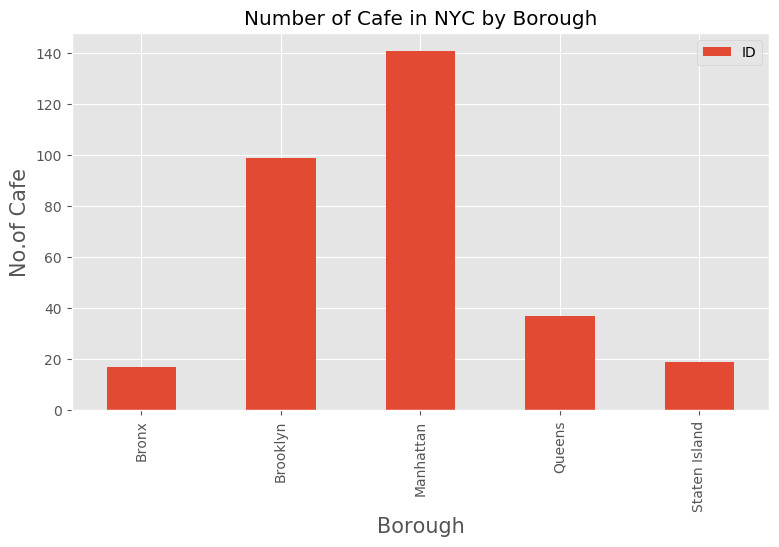

In [23]:
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Cafe in NYC by Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Cafe', fontsize=15)
Cafe_NY.groupby('Borough')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

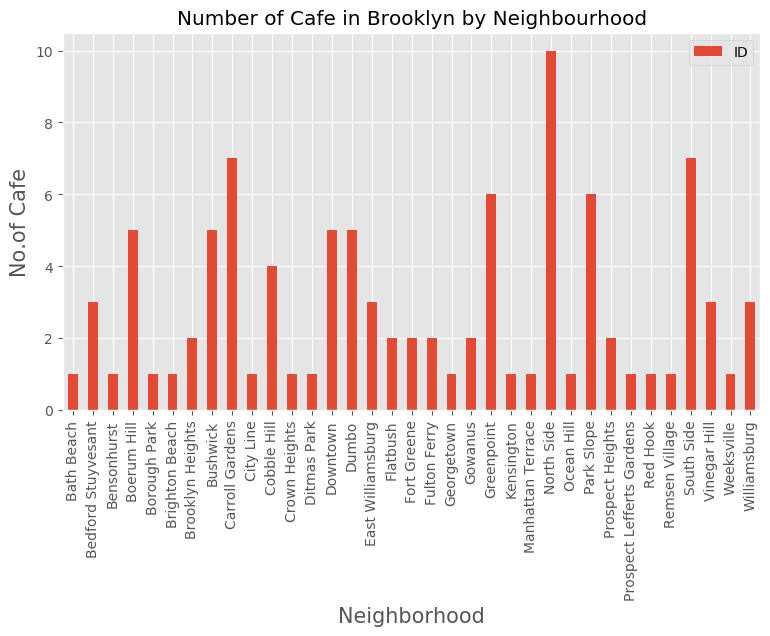

In [63]:
Cafe_Bro = Cafe_NY[Cafe_NY['Borough']=='Brooklyn']

from matplotlib import pyplot as plt
plt.style.use('ggplot')

plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Cafe in Brooklyn by Neighbourhood')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Cafe', fontsize=15)
Cafe_Bro.groupby('Neighborhood')['ID'].count().plot(kind='bar')
plt.legend()
plt.show()

Make a map for all the location of cafe in Now York

In [29]:
map_NYcafe = folium.Map(location=[Latitude, Longitude], zoom_start=10)

for lat, lng, name in zip(Cafe_NY['Latitude'], Cafe_NY['Longitude'], Cafe_NY['Name']):
    label = '{}'.format(name)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='green',
        fill=True,
        fill_color='#56b65d',
        fill_opacity=0.7,
        parse_html=False).add_to(map_NYcafe)  
    
map_NYcafe

Get the likes, rate and tips from Foursquare AIP

### Because of error 429, I could get more info from foursquare api. The following part will show lots of error and I could not get the new data to make the code better. I still keep the old results that is why some of them have right output.

In [72]:
column_names=['Borough', 'Neighborhood', 'ID', 'Name', 'Likes', 'Rating','Tips', 'Latitude', 'Longitude']
CafeStats=pd.DataFrame(columns=column_names)
count=1


for row in Cafe_NY.values.tolist():
    Borough, Neighborhood, ID, Name, Latitude, Longitude = row
    try:
        print(f"Getting venue details for ID {ID}")
        venue_details=get_venue_details(ID)
        print(venue_details)
        id, name, likes, rating, tips=venue_details.values.tolist()[0]
    except (IndexError, KeyError) as e:
        print('No data available for id=',ID)
        likes, rating, tips=[0]*3
    print('(',count,'/',len(Cafe_NY),')','processed')
    CafeStats = CafeStats.append({'Borough': Borough,
                                  'Neighborhood': Neighborhood, 
                                  'ID': id,
                                  'Name' : name,
                                  'Likes' : likes,
                                  'Rating' : rating,
                                  'Tips' : tips,
                                  'Latitude': Latitude,
                                  'Longitude': Longitude 
                                  }, ignore_index=True)
    count+=1

Getting venue details for ID 5660c06b498e4003dba169a5
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc95ef734d51d0ce44d5'}, 'response': {}}
No data available for id= 5660c06b498e4003dba169a5
( 1 / 313 ) processed
Getting venue details for ID 55f81cd2498ee903149fcc64
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc46e4c45d1cb592590f'}, 'response': {}}
No data available for id= 55f81cd2498ee903149fcc64
( 2 / 313 ) processed
Getting venue details for ID 57655be738faa66160da7527
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecca27b1cac5b244d30be'}, 'response': {}}
No data available for id= 57655be738faa66160da7527
( 3 / 313 ) processed
Getting venue details for ID 4c6d5ce5e6b7b1f7af76a98e
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceed

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eccc455b7f95c927cda8a'}, 'response': {}}
No data available for id= 55b02e05498ef881a3a44c6d
( 30 / 313 ) processed
Getting venue details for ID 5d8663bddfbfcc0007278c66
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ece09c23c4000a738262c'}, 'response': {}}
No data available for id= 5d8663bddfbfcc0007278c66
( 31 / 313 ) processed
Getting venue details for ID 5659be63498e1bd863c1e601
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc24e1dddb44ff0595ce'}, 'response': {}}
No data available for id= 5659be63498e1bd863c1e601
( 32 / 313 ) processed
Getting venue details for ID 5ca8ea3cd4cc980039e3729c
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbfe4eef6a1f5bf05a6b'}, 'res

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbcb3dac7251ebfeb351'}, 'response': {}}
No data available for id= 582332f950111c2bcea530e9
( 59 / 313 ) processed
Getting venue details for ID 5e2c4d6803cb1200089cbb9e
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc90f38237072c8f9ee5'}, 'response': {}}
No data available for id= 5e2c4d6803cb1200089cbb9e
( 60 / 313 ) processed
Getting venue details for ID 4a64e954f964a520f6c61fe3
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbe2092d946cb003732f'}, 'response': {}}
No data available for id= 4a64e954f964a520f6c61fe3
( 61 / 313 ) processed
Getting venue details for ID 5b65a1ee6dcf04002cbca38f
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecca261e1700286cd1c95'}, 'res

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc3dea7d8a0a170559a7'}, 'response': {}}
No data available for id= 5b3cdc52c9a517002c585380
( 88 / 313 ) processed
Getting venue details for ID 4a69c95df964a52008cc1fe3
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eca6daf5b017ac0e3d12c'}, 'response': {}}
No data available for id= 4a69c95df964a52008cc1fe3
( 89 / 313 ) processed
Getting venue details for ID 4eba99d3be7b1e562036cb46
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc2ac1067e1669407115'}, 'response': {}}
No data available for id= 4eba99d3be7b1e562036cb46
( 90 / 313 ) processed
Getting venue details for ID 5dcece7b5dd031000867b62e
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eccd239ea89224216d198'}, 'res

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbc77008ac04a86668e5'}, 'response': {}}
No data available for id= 57eeb8e3498e1dd086ebf03f
( 117 / 313 ) processed
Getting venue details for ID 5dbf3656eb5a0d000859a595
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eccc97b1cac5b244d8ea9'}, 'response': {}}
No data available for id= 5dbf3656eb5a0d000859a595
( 118 / 313 ) processed
Getting venue details for ID 59b6f86861f0700444627663
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc4629660202f67b7d50'}, 'response': {}}
No data available for id= 59b6f86861f0700444627663
( 119 / 313 ) processed
Getting venue details for ID 5b0edcd498fbfc002cfcad0e
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbd9bf4f711750a91e08'}, '

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbe93dac7251ebfefd56'}, 'response': {}}
No data available for id= 516bf3c5e4b0e8d4443da599
( 146 / 313 ) processed
Getting venue details for ID 4caf199db4b0a35dc8033ece
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc9237107a76f43ee745'}, 'response': {}}
No data available for id= 4caf199db4b0a35dc8033ece
( 147 / 313 ) processed
Getting venue details for ID 59f337859e3b65154afaaa14
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc4b71d24c79fab56540'}, 'response': {}}
No data available for id= 59f337859e3b65154afaaa14
( 148 / 313 ) processed
Getting venue details for ID 536fe442498e193806dedd8f
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecaec0155757212b14aae'}, '

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eccc8beb40e33873321d0'}, 'response': {}}
No data available for id= 573498df498e6df2eb8b36a7
( 175 / 313 ) processed
Getting venue details for ID 49ee02e9f964a52010681fe3
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecaf5221cc778ccf6090b'}, 'response': {}}
No data available for id= 49ee02e9f964a52010681fe3
( 176 / 313 ) processed
Getting venue details for ID 5418490f498e4d3bb75c7bcc
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc8cbf216839f17bfda4'}, 'response': {}}
No data available for id= 5418490f498e4d3bb75c7bcc
( 177 / 313 ) processed
Getting venue details for ID 5b8c24546dcf04002c9c673c
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ec9e910e2090c53de3f66'}, '

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eca7aeac69b39123dbfdd'}, 'response': {}}
No data available for id= 5b9586483d4791002c832b13
( 204 / 313 ) processed
Getting venue details for ID 53b6b632498ebfb1ade29958
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eccd2beb40e33873339f1'}, 'response': {}}
No data available for id= 53b6b632498ebfb1ade29958
( 205 / 313 ) processed
Getting venue details for ID 4b959d5bf964a52042ac34e3
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5eca45ce204e4376924629'}, 'response': {}}
No data available for id= 4b959d5bf964a52042ac34e3
( 206 / 313 ) processed
Getting venue details for ID 54858fb9498e5a6cf73d6dee
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbfd3dac7251ebff30f1'}, '

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecc6871d24c79fab5ad9e'}, 'response': {}}
No data available for id= 4e4dcd00bd41b76bef93518f
( 233 / 313 ) processed
Getting venue details for ID 5ce097771de765002cda6a31
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecac374a5df730651b3df'}, 'response': {}}
No data available for id= 5ce097771de765002cda6a31
( 234 / 313 ) processed
Getting venue details for ID 4f32062d19833175d60ac132
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecd0e4e9d922fc3e5f4a8'}, 'response': {}}
No data available for id= 4f32062d19833175d60ac132
( 235 / 313 ) processed
Getting venue details for ID 5bf864d5829b0c002c7f65b6
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecaefbf857f310f38b3f3'}, '

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecbeab1b64913a5122393'}, 'response': {}}
No data available for id= 4f22b060e4b02a95fc886761
( 262 / 313 ) processed
Getting venue details for ID 5c7d2d843d4791002c881f1c
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecb4c28068f03590b1cf4'}, 'response': {}}
No data available for id= 5c7d2d843d4791002c881f1c
( 263 / 313 ) processed
Getting venue details for ID 5941bb256f706a35169d1b7a
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecb4230a4821ff057a8d9'}, 'response': {}}
No data available for id= 5941bb256f706a35169d1b7a
( 264 / 313 ) processed
Getting venue details for ID 56093809498e5344ab8835a6
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecd6505a91c34dcf8fbef'}, '

dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecb01bf857f310f38dda9'}, 'response': {}}
No data available for id= 5b9d8e69b6eedb002c72a39e
( 291 / 313 ) processed
Getting venue details for ID 5890d8aecc5b6a43d6daa0f9
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecacf4be90c6db31598c5'}, 'response': {}}
No data available for id= 5890d8aecc5b6a43d6daa0f9
( 292 / 313 ) processed
Getting venue details for ID 4b749ffdf964a5208ce82de3
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecb15b5de2b6f48b145e3'}, 'response': {}}
No data available for id= 4b749ffdf964a5208ce82de3
( 293 / 313 ) processed
Getting venue details for ID 59286a3a12f0a919d922f5ca
dave debug: {'meta': {'code': 429, 'errorType': 'quota_exceeded', 'errorDetail': 'Quota exceeded', 'requestId': '5f5ecd1539ea892242177874'}, '

In [71]:
CafeStats.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips,Latitude,Longitude
0,Bronx,Kingsbridge,0,0,0,0,0,40.881687,-73.902818
1,Manhattan,Marble Hill,0,0,0,0,0,40.876551,-73.910660
2,Manhattan,Marble Hill,0,0,0,0,0,40.876551,-73.910660
3,Bronx,Norwood,0,0,0,0,0,40.877224,-73.879391
4,Bronx,Pelham Parkway,0,0,0,0,0,40.857413,-73.854756


In [36]:
CafeStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       313 non-null    object 
 1   Neighborhood  313 non-null    object 
 2   ID            313 non-null    object 
 3   Name          313 non-null    object 
 4   Likes         313 non-null    object 
 5   Rating        313 non-null    float64
 6   Tips          313 non-null    object 
dtypes: float64(1), object(6)
memory usage: 17.2+ KB


In [38]:
CafeStats['Likes'] = CafeStats['Likes'].astype('float64')
CafeStats['Tips'] = CafeStats['Tips'].astype('float64')
CafeStats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 313 entries, 0 to 312
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       313 non-null    object 
 1   Neighborhood  313 non-null    object 
 2   ID            313 non-null    object 
 3   Name          313 non-null    object 
 4   Likes         313 non-null    float64
 5   Rating        313 non-null    float64
 6   Tips          313 non-null    float64
dtypes: float64(3), object(4)
memory usage: 17.2+ KB


In [39]:
CafeStats.sort_values(['Rating'],ascending=False).head(15)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
46,Brooklyn,Carroll Gardens,58d933702f91cb026f478e38,East One Coffee Roasters,242.0,9.2,34.0
47,Brooklyn,Carroll Gardens,5d7ce692b4fc9c0008394021,Hungry Ghost,19.0,8.9,0.0
16,Brooklyn,Greenpoint,576eb1f5cd10a371033f7ad6,Maman,175.0,8.9,36.0
15,Brooklyn,Greenpoint,518cf9ec498e8c38bda0268d,Homecoming,215.0,8.8,44.0
33,Brooklyn,Bushwick,55e9fe71498e8edb034385a7,Dweebs,86.0,8.8,20.0
28,Brooklyn,Prospect Heights,5a6cc216f5e9d763b7a37c8f,Gran Caffe De Martini,25.0,8.8,7.0
29,Brooklyn,Williamsburg,55b02e05498ef881a3a44c6d,The Flat's BK Speed Coffee,83.0,8.7,16.0
27,Brooklyn,Prospect Heights,4a2407e6f964a520ef7d1fe3,Sit & Wonder,304.0,8.7,116.0
41,Brooklyn,Brooklyn Heights,59d7872e5a2c911745c2e8ca,Joe Coffee,92.0,8.7,12.0
7,Bronx,Van Nest,4c1c5630e9c4ef3b4ccd45aa,Conti's Pastry Shoppe,47.0,8.5,15.0


In [40]:
CafeStats.sort_values(['Likes'],ascending=False).head(15)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
40,Brooklyn,Brooklyn Heights,4de26e06814df7ebdc14af8b,Vineapple Cafe,465.0,8.4,151.0
27,Brooklyn,Prospect Heights,4a2407e6f964a520ef7d1fe3,Sit & Wonder,304.0,8.7,116.0
43,Brooklyn,Cobble Hill,55423f82498e5156ac21cfb6,Swallow Cafe,253.0,7.9,47.0
46,Brooklyn,Carroll Gardens,58d933702f91cb026f478e38,East One Coffee Roasters,242.0,9.2,34.0
15,Brooklyn,Greenpoint,518cf9ec498e8c38bda0268d,Homecoming,215.0,8.8,44.0
16,Brooklyn,Greenpoint,576eb1f5cd10a371033f7ad6,Maman,175.0,8.9,36.0
20,Brooklyn,Greenpoint,55cf6244498e24c4ebe3ae0b,Sweetleaf,169.0,8.5,24.0
19,Brooklyn,Greenpoint,4d8f7d48d265236a02c72117,Upright Coffee,157.0,7.8,49.0
21,Brooklyn,Brighton Beach,4b59aedcf964a520999228e3,Starbucks,129.0,6.5,37.0
41,Brooklyn,Brooklyn Heights,59d7872e5a2c911745c2e8ca,Joe Coffee,92.0,8.7,12.0


In [41]:
CafeStats.sort_values(['Tips'],ascending=False).head(15)

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
40,Brooklyn,Brooklyn Heights,4de26e06814df7ebdc14af8b,Vineapple Cafe,465.0,8.4,151.0
27,Brooklyn,Prospect Heights,4a2407e6f964a520ef7d1fe3,Sit & Wonder,304.0,8.7,116.0
19,Brooklyn,Greenpoint,4d8f7d48d265236a02c72117,Upright Coffee,157.0,7.8,49.0
43,Brooklyn,Cobble Hill,55423f82498e5156ac21cfb6,Swallow Cafe,253.0,7.9,47.0
36,Brooklyn,Bushwick,4ee74dca7ee5cae3f273d82e,Central Cafe,61.0,6.2,45.0
15,Brooklyn,Greenpoint,518cf9ec498e8c38bda0268d,Homecoming,215.0,8.8,44.0
21,Brooklyn,Brighton Beach,4b59aedcf964a520999228e3,Starbucks,129.0,6.5,37.0
16,Brooklyn,Greenpoint,576eb1f5cd10a371033f7ad6,Maman,175.0,8.9,36.0
46,Brooklyn,Carroll Gardens,58d933702f91cb026f478e38,East One Coffee Roasters,242.0,9.2,34.0
23,Brooklyn,Flatbush,5172b2d4498e646485496d05,Coffee Mob,84.0,7.8,29.0


make a map by rating

In [ ]:
A = CafeStats[CafeStats['Rating'] >= 7.5]
B = CafeStats[np.bitwise_and(CafeStats['Rating'] >= 3.1, CafeStats['Rating'] < 7.5)]
C = CafeStats[CafeStats['Rating'] < 3.1]

In [67]:
map_NYcafeRating = folium.Map(location=[Latitude, Longitude], zoom_start=10)

for m, c, cf in [(A, 'green', '#45ad72'), (B, 'yellow', '#eee25e'), (C, 'red', '#ad454c')]:
    for lat, lng, name, rating in zip(m['Latitude'], m['Longitude'], m['Name'], m['Rating']):
        label = '{},{}'.format(name, rating)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=c,
            fill=True,
            fill_color=cf,
            fill_opacity=0.7,
            parse_html=False).add_to(map_NYcafe)  
    
map_NYcafeRating

KeyError: 'Latitude'